### First own regression model
##### In this Notebook, I will design a first regression model on drugCombDB data exploiting physical properties
The model orient itself at the solubility prediction article.
- First I have to find SMILES for the drugs
- then compute different physical KPIs
- finally train a regression model

notes:<br>
1. Loads of missing values, for now all dropped, costs me 450k out of the 500k records
2. some cids have different strings. Dropped for now

In [1]:
import pandas as pd
from rdkit import Chem

In [2]:
# getting chemical descriptors
chemDescr = pd.read_csv("./drugCombDBdata/descriptions/drug_chemical_info.csv")
chemDescr

,drugName,cIds,drugNameOfficial,molecularWeight,smilesString
0,Bendamustine,CIDs00065628,bendamustine,358.26284,CN1C2=C(C=C(C=C2)N(CCCl)CCCl)N=C1CCCC(=O)O
1,Lonidamine,CIDs00039562,lonidamine,321.15810,C1=CC=C2C(=C1)C(=NN2CC3=C(C=C(C=C3)Cl)Cl)C(=O)O
2,Lenalidomide,CIDs00216326,lenalidomide,259.26062,C1CC(=O)NC(=O)C1N2CC3=C(C2=O)C=CC=C3N
3,Cladribine,CIDs00020279,cladribine,285.68698,C1C(C(OC1N2C=NC3=C2N=C(N=C3N)Cl)CO)O
4,Pentostatin,CIDs00439693,pentostatin,268.26914,C1C(C(OC1N2C=NC3=C2NC=NCC3O)CO)O
...,...,...,...,...,...
3054,ELOXATIN (TN) (SANOFI SYNTHELAB),CIDs24197464,none,0.00000,none
3055,EMCYT (PHARMACIA),CIDs54611422,none,0.00000,none
3056,CISPLATINO,CIDs00441203,none,0.00000,none
3057,NSC707389,CIDs54611489,none,0.00000,none


In [34]:
# we see some smiles are missing
print(len(chemDescr[chemDescr["smilesString"]=="none"]))
# since it is only the case for 30 of more than 3000 rows, I'll drop them
chemDescr=chemDescr[chemDescr["smilesString"]!="none"]
from rdkit import Chem
from rdkit.Chem import Descriptors

from rdkit.Chem import MACCSkeys
chemDescr = chemDescr[~pd.isna(chemDescr["smilesString"])]
chemDescr["mol-object"]=[Chem.MolFromSmiles(mol) for mol in chemDescr["smilesString"]]
chemDescr["MACCSk"] = [Chem.MACCSkeys.GenMACCSKeys(mol) for mol in chemDescr["mol-object"]]

#new ones
chemDescr["Num H-Accptors"] = [Chem.Descriptors.NumHAcceptors(mol) for mol in chemDescr["mol-object"]]
chemDescr["Num H-Donors"] = [Chem.Descriptors.NumHDonors(mol) for mol in chemDescr["mol-object"]]
chemDescr["NH/OH count"] = [Chem.Descriptors.NHOHCount(mol) for mol in chemDescr["mol-object"]]
print(len(chemDescr))
chemDescr.drop_duplicates(subset=["cIds"],inplace=True) # deleting
chemDescr.head(2)

0
2506


,drugName,cIds,drugNameOfficial,molecularWeight,smilesString,mol-object,MACCSk,Num H-Accptors,Num H-Donors,NH/OH count
0,Bendamustine,CIDs00065628,bendamustine,358.26284,CN1C2=C(C=C(C=C2)N(CCCl)CCCl)N=C1CCCC(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7d19e08628f0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,1,1
1,Lonidamine,CIDs00039562,lonidamine,321.15810,C1=CC=C2C(=C1)C(=NN2CC3=C(C=C(C=C3)Cl)Cl)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7d19e0862850>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,1,1


In [35]:
data = pd.read_csv("drugCombDBdata/synergy-score-data/REGRdrugcombs_scored.csv")
data

,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA
0,1,5-FU,ABT-888,A2058,1.720,6.260,-2.750,5.540
1,2,5-FU,ABT-888,A2058,5.880,12.330,3.330,11.610
2,3,5-FU,ABT-888,A2058,3.590,11.660,2.650,10.940
3,4,5-FU,ABT-888,A2058,-0.850,5.150,-3.860,4.430
4,5,5-FU,AZD1775,A2058,12.290,15.770,10.400,18.660
...,...,...,...,...,...,...,...,...
498860,498861,Mitomycin C,Valproic acid sodium salt,DIPG25,-3.076,-11.124,-6.078,-6.367
498861,498862,Cyanein,Valproic acid sodium salt,DIPG25,1.320,-1.091,-16.157,1.139
498862,498863,Erlotinib,Valproic acid sodium salt,DIPG25,-15.768,-15.776,-25.465,-6.212
498863,498864,Bafilomycin A1,Valproic acid sodium salt,DIPG25,2.208,10.567,-9.455,1.525


In [5]:
# I thought I can just make up a lot of values about those numbers, but I don't know yet how to find a synergy value for 2 vars
# maybe I can try the absolute differences between them

# check how they computed HSA etc and see if you canb

In [6]:
# OLD
#temp=chemDescr.loc[:,["drugName","cIds","smilesString","mol-object"]].set_index("drugName")
#smilesHSAtable = data.join(temp,on="Drug1",how="left")
#smilesHSAtable.rename(columns={"smilesString":"Drug1 smiles","cIds":"Drug1 cId"},inplace=True)


In [7]:
#joinging cids, smiles to the data
temp=chemDescr.loc[:,["drugName","cIds","smilesString","mol-object","MACCSk","Num H-Accptors","Num H-Donors","NH/OH count"]].set_index("drugName")

smilesHSAtable = data.join(temp,on="Drug1",how="left")
smilesHSAtable.rename(columns={"smilesString":"Drug1 smiles","cIds":"Drug1 cId","mol-object":"Drug1 mol","MACCSk":"MACCSk1","Num H-Accptors":"D1 Num H-Acceptors","Num H-Donors":"D1 H-Donors","NH/OH count":"D1 NH/OH count"},inplace=True)

smilesHSAtable = smilesHSAtable.join(temp,on="Drug2",how="left")
smilesHSAtable.rename(columns={"smilesString":"Drug2 smiles","cIds":"Drug2 cId","mol-object":"Drug2 mol","MACCSk":"MACCSk2","Num H-Accptors":"D2 Num H-Acceptors","Num H-Donors":"D2 H-Donors","NH/OH count":"D2 NH/OH count"},inplace=True)

del temp
print(len(smilesHSAtable))
smilesHSAtable.head(3)

498865


,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA,Drug1 cId,Drug1 smiles,...,D1 Num H-Acceptors,D1 H-Donors,D1 NH/OH count,Drug2 cId,Drug2 smiles,Drug2 mol,MACCSk2,D2 Num H-Acceptors,D2 H-Donors,D2 NH/OH count
0,1,5-FU,ABT-888,A2058,1.72,6.26,-2.75,5.54,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,5-FU,ABT-888,A2058,5.88,12.33,3.33,11.61,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,5-FU,ABT-888,A2058,3.59,11.66,2.65,10.94,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# still a lot of NaN values, for now dropping them
temp = smilesHSAtable[~pd.isna(smilesHSAtable["Drug2 smiles"])]
temp = temp[~pd.isna(temp["Drug1 smiles"])]
#temp = temp
shortData=temp
del temp
print(str(len(shortData))+" of almost 500k entries just bc of nan value")
del smilesHSAtable
shortData.reset_index(inplace=True)
shortData.head(2)

39260 of almost 500k entries just bc of nan value


,index,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA,Drug1 cId,...,D1 Num H-Acceptors,D1 H-Donors,D1 NH/OH count,Drug2 cId,Drug2 smiles,Drug2 mol,MACCSk2,D2 Num H-Acceptors,D2 H-Donors,D2 NH/OH count
0,192,193,BEZ-235,MK-8776,A2058,9.73,8.15,10.19,15.11,CIDs11977753,...,6.0,0.0,0.0,CIDs46239015,CN1C=C(C=N1)C2=C3N=C(C(=C(N3N=C2)N)Br)C4CCCNC4,<rdkit.Chem.rdchem.Mol object at 0x7d19e02327b0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.0,2.0,3.0
1,193,194,BEZ-235,MK-8776,A2058,8.19,6.61,8.66,13.58,CIDs11977753,...,6.0,0.0,0.0,CIDs46239015,CN1C=C(C=N1)C2=C3N=C(C(=C(N3N=C2)N)Br)C4CCCNC4,<rdkit.Chem.rdchem.Mol object at 0x7d19e02327b0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.0,2.0,3.0


In [9]:
# now recreating the 4 properties from solubility article
# I hope to be able to reuse the generate function I wrote 2 weeks ago:
from mediumArticleSolubility.mediumArticleFunctionGenerate import generate
temp1 = generate(chemDescr["mol-object"])
temp1["cId"]=chemDescr["cIds"]

# cross checking if indexing worked
print("CIDs00003385")
print(generate([chemDescr["mol-object"][chemDescr["cIds"]=="CIDs00039562"].iloc[0]]))

import copy
temp2=copy.copy(temp1)
temp1.head(2)

CIDs00003385
   MolLogP    MolWt  NumRotatableBonds
0   4.0896  321.163                  3


,MolLogP,MolWt,NumRotatableBonds,cId
0,3.2646,358.269,9,CIDs00065628
1,4.0896,321.163,3,CIDs00039562


In [10]:
temp1.rename(columns={"cId":"Drug1 cId","NumRotatableBonds":"D1 NumRotatableBonds","MolWt":"D1 MolWt","MolLogP":"D1 MolLogP"},inplace=True)
temp1.set_index("Drug1 cId",inplace=True)
shortData=shortData.join(temp1,on="Drug1 cId",how="left")

temp2.rename(columns={"cId":"Drug2 cId","NumRotatableBonds":"D2 NumRotatableBonds","MolWt":"D2 MolWt","MolLogP":"D2 MolLogP"},inplace=True)
temp2.set_index("Drug2 cId",inplace=True)
shortData=shortData.join(temp2,on="Drug2 cId",how="left")

shortData.head(2)

,index,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA,Drug1 cId,...,MACCSk2,D2 Num H-Acceptors,D2 H-Donors,D2 NH/OH count,D1 MolLogP,D1 MolWt,D1 NumRotatableBonds,D2 MolLogP,D2 MolWt,D2 NumRotatableBonds
0,192,193,BEZ-235,MK-8776,A2058,9.73,8.15,10.19,15.11,CIDs11977753,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.0,2.0,3.0,5.6645,413.498,2.0,3.2688,340.39,3.0
1,193,194,BEZ-235,MK-8776,A2058,8.19,6.61,8.66,13.58,CIDs11977753,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.0,2.0,3.0,5.6645,413.498,2.0,3.2688,340.39,3.0


In [11]:
# D1 computing aromatic proportion
aromAtoms = [
sum([shortData["Drug1 mol"][j].GetAtomWithIdx(i).GetIsAromatic() 
for i in range(shortData["Drug1 mol"][j].GetNumAtoms())]) 
for j in range(len(shortData["Drug1 mol"]))
]
heavyAtoms=[Chem.Descriptors.HeavyAtomCount(shortData["Drug1 mol"][i]) for i in range (len(shortData["Drug1 mol"]))]

In [12]:
# D2 computing aromatic proportion
aromAtoms2 = [
sum([shortData["Drug2 mol"][j].GetAtomWithIdx(i).GetIsAromatic() 
for i in range(shortData["Drug2 mol"][j].GetNumAtoms())]) 
for j in range(len(shortData["Drug2 mol"]))
]
heavyAtoms2=[Chem.Descriptors.HeavyAtomCount(shortData["Drug2 mol"][i]) for i in range (len(shortData["Drug2 mol"]))]

In [13]:
import numpy as np
shortData["D1 Arom. Prop."] = np.round(
    (np.array(aromAtoms)/np.array(heavyAtoms)),
    decimals=2)
shortData["D2 Arom. Prop."] = np.round(
    (np.array(aromAtoms2)/np.array(heavyAtoms2)),
    decimals=2)
del aromAtoms
del aromAtoms2

shortData.head(2)

,index,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA,Drug1 cId,...,D2 H-Donors,D2 NH/OH count,D1 MolLogP,D1 MolWt,D1 NumRotatableBonds,D2 MolLogP,D2 MolWt,D2 NumRotatableBonds,D1 Arom. Prop.,D2 Arom. Prop.
0,192,193,BEZ-235,MK-8776,A2058,9.73,8.15,10.19,15.11,CIDs11977753,...,2.0,3.0,5.6645,413.498,2.0,3.2688,340.39,3.0,0.81,0.61
1,193,194,BEZ-235,MK-8776,A2058,8.19,6.61,8.66,13.58,CIDs11977753,...,2.0,3.0,5.6645,413.498,2.0,3.2688,340.39,3.0,0.81,0.61


In [14]:
# now you can do what discussed with thomas first bullshit linear regression (maybe through difference or ratio)
# then kNN and random forrest (or a tree at first maybe)

#### thoughts on kNN & trees: Finding similar cases and then going with the nearest neighbours.
--easy thought: Dimensionality reduction, but what would that look like? <br>
can in principle work, especially when doubling the data -- then the order of the properties does not matter or the questions on how they interact, we just look for similar cases<br><br>
trees could work more straightforward, just by splitting the data according to rules finding something - then random forresting it
Problem: both work mainly for classification task

In [20]:
from sklearn.model_selection import train_test_split
knnData=shortData.dropna().iloc[:,23:31]
knnData["HSAscores"]=shortData.dropna()["HSA"]

X_train, x_test,Y_train, y_test = train_test_split(knnData.iloc[:,0:8],knnData.iloc[:,8],test_size=0.33)

In [40]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=3) #do hyperparameter tuning of k here
neigh.fit(X_train,Y_train)

print(neigh.predict(x_test[0:5]))
print(y_test[0:5])

[-0.86866667  1.89266667  3.57733333  2.17633333  2.285     ]
29567   -0.769
26467    3.320
36644    2.881
9914     2.430
29465    5.514
Name: HSA, dtype: float64


In [44]:
# MSE does not make much sense
from sklearn.metrics import mean_squared_error
#mean_squared_error(neigh.predict(x_test),y_test)
mean_squared_error(neigh.predict(x_test),y_test)

138.05991038735442

In [22]:
#shortData["D1 MolLogP"]/shortData["D2 MolLogP"]
y_test

37484    -6.484
23700     7.201
35098     0.975
25456     4.954
1132    -30.360
          ...  
27016     0.088
340       6.950
22800    -0.923
38416     2.024
35587     0.058
Name: HSAscores, Length: 5462, dtype: float64

Thoughts on interactions: I must model the interactions somehow. There are 3 interaction types or so I believe, working at the same site, working sequentially or inhibiting inhibitors I think<br><br>

main question at ammar next time: how can we do this??

In [23]:
import pandas as pd
drugTargetInt=pd.read_csv("./drugCentral/drug.target.interaction.tsv",sep="\t")
drugTargetInt.head(2)

,DRUG_NAME,STRUCT_ID,TARGET_NAME,TARGET_CLASS,ACCESSION,GENE,SWISSPROT,ACT_VALUE,ACT_UNIT,ACT_TYPE,ACT_COMMENT,ACT_SOURCE,RELATION,MOA,MOA_SOURCE,ACT_SOURCE_URL,MOA_SOURCE_URL,ACTION_TYPE,TDL,ORGANISM
0,levobupivacaine,4,Potassium voltage-gated channel subfamily H me...,Ion channel,Q12809,KCNH2,KCNH2_HUMAN,4.89,NaN,IC50,Inhibition of wild-type human ERG channel expr...,CHEMBL,=,NaN,NaN,NaN,NaN,NaN,Tclin,Homo sapiens
1,levobupivacaine,4,Sodium channel protein type 1 subunit alpha,Ion channel,P35498,SCN1A,SCN1A_HUMAN,5.79,NaN,IC50,NaN,WOMBAT-PK,=,NaN,NaN,NaN,NaN,NaN,Tclin,Homo sapiens


USE MOLECULAR SIMILARITY FOR REGRESSION TASK<br>
...structural keys: Bit Strings (MACCS keys & Pubchem fingerprint) encode structural information

In [24]:
from rdkit import Chem
from rdkit import DataStructs

mols = [Chem.MolFromSmiles("CCOC"),Chem.MolFromSmiles("COC")] #if it says chem has no attribute MACCSkeys thats a system error
maccsk = [Chem.MACCSkeys.GenMACCSKeys(mols[0]),Chem.MACCSkeys.GenMACCSKeys(mols[1])]
DataStructs.FingerprintSimilarity(maccsk[0],maccsk[1])

0.5384615384615384

Trying to do a linear regression for drug1 mol and drug2 mol<br>
for computational reasons edit code above to get MACCS keys in shortData

In [25]:
shortData.head(1)

,index,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA,Drug1 cId,...,D2 H-Donors,D2 NH/OH count,D1 MolLogP,D1 MolWt,D1 NumRotatableBonds,D2 MolLogP,D2 MolWt,D2 NumRotatableBonds,D1 Arom. Prop.,D2 Arom. Prop.
0,192,193,BEZ-235,MK-8776,A2058,9.73,8.15,10.19,15.11,CIDs11977753,...,2.0,3.0,5.6645,413.498,2.0,3.2688,340.39,3.0,0.81,0.61


In [26]:
shortData["FingerprintSimilarity"]=[DataStructs.FingerprintSimilarity(
    shortData.loc[:,"MACCSk1"][row],
    shortData.loc[:,"MACCSk2"][row])
    for row in range(len(shortData))]
shortData.head(2)

,index,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA,Drug1 cId,...,D2 NH/OH count,D1 MolLogP,D1 MolWt,D1 NumRotatableBonds,D2 MolLogP,D2 MolWt,D2 NumRotatableBonds,D1 Arom. Prop.,D2 Arom. Prop.,FingerprintSimilarity
0,192,193,BEZ-235,MK-8776,A2058,9.73,8.15,10.19,15.11,CIDs11977753,...,3.0,5.6645,413.498,2.0,3.2688,340.39,3.0,0.81,0.61,0.430556
1,193,194,BEZ-235,MK-8776,A2058,8.19,6.61,8.66,13.58,CIDs11977753,...,3.0,5.6645,413.498,2.0,3.2688,340.39,3.0,0.81,0.61,0.430556


In [54]:
regrData=shortData[~np.array(shortData.loc[:,"HSA"]<-20)] #eliminate quantiles rather than inventing your own borders
regrData=regrData[~np.array(regrData.loc[:,"HSA"]>20)]
X_train, x_test,Y_train, y_test = train_test_split(regrData.loc[:,"FingerprintSimilarity"],regrData.loc[:,"HSA"],test_size=0.33)

In [28]:
X_train=np.array(X_train).reshape(-1, 1)
x_test=np.array(x_test).reshape(-1, 1)

In [29]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, Y_train)
print(model.coef_)
print(model.intercept_)
model.score(x_test,y_test) # r squared

[2.00745788]
-0.31443692967912384


0.0008564184525510221

The share of explained variation is extremely small, i.e. not a very good model. Let's plot it

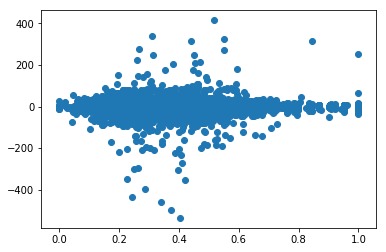

In [52]:
# do this for test and train set separately, does not mean that is the same distribution in both sets
import matplotlib.pyplot as plt

plt.scatter(regrData.loc[:,"FingerprintSimilarity"],regrData.loc[:,"HSA"])

Try connect more bio data<br>
Potentially interesing chemical descriptors from rdkit:<br>
NumHAcceptors, NumHDonors, NumAmideBonds for a kNN?

In [31]:
shortData.columns

Index(['index', 'ID', 'Drug1', 'Drug2', 'Cell line', 'ZIP', 'Bliss', 'Loewe',
       'HSA', 'Drug1 cId', 'Drug1 smiles', 'Drug1 mol', 'MACCSk1',
       'D1 Num H-Acceptors', 'D1 H-Donors', 'D1 NH/OH count', 'Drug2 cId',
       'Drug2 smiles', 'Drug2 mol', 'MACCSk2', 'D2 Num H-Acceptors',
       'D2 H-Donors', 'D2 NH/OH count', 'D1 MolLogP', 'D1 MolWt',
       'D1 NumRotatableBonds', 'D2 MolLogP', 'D2 MolWt',
       'D2 NumRotatableBonds', 'D1 Arom. Prop.', 'D2 Arom. Prop.',
       'FingerprintSimilarity'],
      dtype='object')

In [32]:
shortData.head(2)

,index,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA,Drug1 cId,...,D2 NH/OH count,D1 MolLogP,D1 MolWt,D1 NumRotatableBonds,D2 MolLogP,D2 MolWt,D2 NumRotatableBonds,D1 Arom. Prop.,D2 Arom. Prop.,FingerprintSimilarity
0,192,193,BEZ-235,MK-8776,A2058,9.73,8.15,10.19,15.11,CIDs11977753,...,3.0,5.6645,413.498,2.0,3.2688,340.39,3.0,0.81,0.61,0.430556
1,193,194,BEZ-235,MK-8776,A2058,8.19,6.61,8.66,13.58,CIDs11977753,...,3.0,5.6645,413.498,2.0,3.2688,340.39,3.0,0.81,0.61,0.430556


In [33]:
from rdkit.Chem import Descriptors
print(Descriptors.NumHAcceptors(shortData.loc[6500,"Drug1 mol"]))
print(Descriptors.NumHDonors(shortData.loc[6500,"Drug1 mol"]))


3
1


NOTE: for changing molecular descriptors, it is better to do this in the smaller table of drugs, not in this big one <br>
for this reason search for the lines that starts with<br>
"we see some smiles are missing" <br>
add something like <br>
chemDescr["MACCSk"] = [Chem.MACCSkeys.GenMACCSKeys(mol) for mol in chemDescr["mol-object"]] <br>
and change that in the joining block below as well


19
